# [Optiver] Simple LGBM for beginner (Eng/日本語)

2023/10/11 Update  
Apologies: In my previous version, I forgot to change the objective of LGBMRegressor from regression to mae, which is evaluation method in this competition, when I copied and edited from my personal notebook. I modified that, and accordingly public score or the result of various approach in this notebook was changed, thus I updated the descriptions in multiple places.  

お詫び：以前掲載していたバージョンでは、Private Notebookから移して編集する際にLGBMRegressorのobjectiveをRegressonのままにしていて今回の評価方式であるMAEに修正することを失念していました。今回修正を行った結果、各種アプローチに伴うスコアや結果が変更となりましたので、複数箇所の記載を更新しています。  

This competition is to build the model to predict the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stockthe closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock.  
In my impression, many competitions of recent Kagglerecent Kaggle were for Image recognition or Natural language processing, and we haven't had Table competition for a long time.  
When it comes to Optiver, there was Optiver's competition to predict the volatility of the stocks 2 years ago, which was my 2nd competition to perticipate as a beginner. Still, Table competition seems easier for beginners than Image recognition or NLP or something like. This is why I'd like to introduce a simple LGBM model and how to improve the score, while the score has not been so good yet.   
I'd be happy if you could refer to this notebook just a starter and enjoy Kaggle, trying various approaches to improve the score by yourself.

今回のお題は、オーダーブックと株式のクロージングオークションのデータを使用して何百にも及ぶNASDAQ上場株式の終値の動きを予想するモデルを構築するというものです。  
最近Kaggleでは画像認識や自然言語系のコンペが多かった印象ですので、最近Kaggleでは画像認識や自然言語系のコンペが多かった印象ですので、久しぶりのテーブル系コンペのように思われます。  
Optiverと言えば、2年前も株式のVolatilityを予測するというコンペがあり、私もそれがコンペデビュー2戦目でした。初心者にはやはり画像認識等よりテーブル系のほうが取り組みやすくて有り難いですね。  
ということで、例によってスコアは余り高くないですが、初心者の方向けにシンプルなLGBMとスコア改善のアプローチをご紹介したいと思います。スターターとの位置づけですので、色々と試行錯誤をしてスコアを伸ばしKaggleを楽しんでいただければ幸いです。

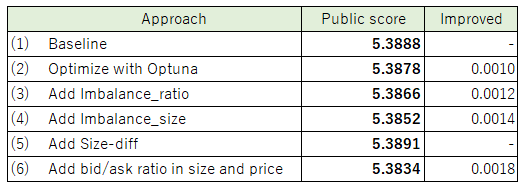

# 1. Baseline

First, just as a baseline, let's feed the training data into LightGBM and see how good public score is procided.

まずは、出発点として、あまり深く考えずに訓練データをLightGBMに投入してどの程度のスコアが出るか見てみます。

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import optuna

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm

optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

from lightgbm import *
pd.set_option("display.max_columns", None)

In [2]:
df_train = pd.read_csv('../input/optiver-trading-at-the-close/train.csv')
df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_sub = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
rev_target = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

In [3]:
df_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
def feature_cols(df) :
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id']]
    df = df[cols]    
    return df

In [5]:
df_train.fillna(0, inplace = True)
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [6]:
lgbm_model = lgbm.LGBMRegressor(objective='mae', n_estimators=500, random_state=1234)
lgbm_model.fit(x_train, y_train)

LGBMRegressor(n_estimators=500, objective='mae', random_state=1234)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

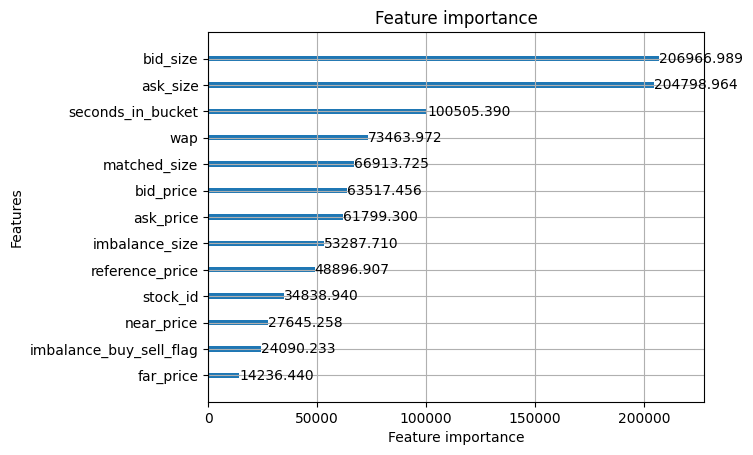

In [7]:
lgbm.plot_importance(lgbm_model, importance_type="gain")

If you submit at this point, the public score will show **5.3888**, which is not so bad. Let's try some approaches from this baseline.

この状態でSubmitするとPublic Scoreは**5.3888**となり、まずまずのスコアとなります。  
ここからスコア改善を図っていきます。

# 2. Optimize parameter with Optuna

Well, changing the approach here, let's see how the score is improved by optimizing the parameters. I used Optuna for optimization. As a result, Public score was improved to **5.3878**.

いったんここで、パラメーターを最適化してどの程度スコアが良くなるか見てみます。最適化にはOptunaを使いました。  
結果、スコアは**5.3878**へと改善しました。

In [8]:
x = x_train.copy()
y = y_train.copy()

In [9]:
def objective(trial):
    params = {
        'random_seed':123,
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 1000),
        'num_leaves'      :trial.suggest_int('num_leaves', 4, 32),
        'max_depth'       :trial.suggest_int("max_depth",1,10)}
            
    model = lgbm.LGBMRegressor(**params)
    model.fit(x,y)
    y_pred = model.predict(x)
    score = mean_absolute_error(y, y_pred)
    
    return score

In [10]:
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
#study.optimize(objective, n_trials=50) 
#study.best_params

Above optimization is Comment-out, since it takes a couple of hours to run this optimization。If you are curious, it may be interesting if you try to optimize various parameters after removing comment-out.

Optunaを走らせると２・３時間かかるので、ここではコメントアウトしていますが、以下のように最適化結果が表示されます。興味のある方はコメントアウトを外して、これ以外のパラメーターの変更も試してみると面白いかもしれません。

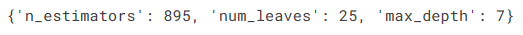

# 3. Add imbalance_size

Next, let's see how the score is improved by adding new features.  
As you can see the Light GBM "importance" in the above Section 1, not Price-related but Size-related features were regarded as important by LightGBM, thus try to create Size-related new features. First, let's create the ratio between imbalance_size and matched_size.  

さらに特徴量を加えてスコア改善するかを見てみます。  
上記１で特徴量のImportanceを見た際、PriceではなくSizeに関するものが上位を占めていましたので、Sizeに関連する新しい特徴量を作ってみます。まずはimbalance_sizeとmatched_sizeとの比率を新たな特徴として加えてみます。
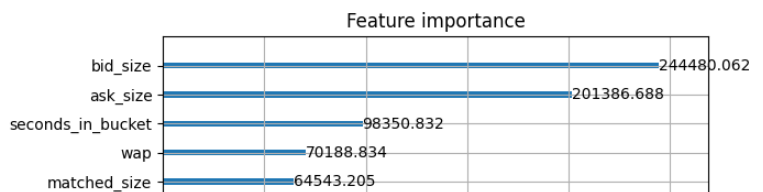

The result is Puclic score was improved to **5.3866** as expected.  

結果、スコアは**5.3866**へと順調に改善しました。

In [11]:
#def pre_process1(df):
#    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
#    return df

# 4. Add imbalance_size

Then, let's try to add 2 more features related to imbalance between bid-size and ask-size, which will improve Public score to **5.3852**.  

次に、bid-sizeとask-sizeも用いてbidとaskの不均衡さに関する特徴量を二つ追加します。  
この結果、スコアは**5.3852**へと改善しました。

For these features, I referred to below great notebook.   
https://www.kaggle.com/code/renatoreggiani/optv-lightgbm

In [12]:
#def pre_process1(df):
#       
#    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
#    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
#    
#    return df

# 5. Try to use "diff" #

I tried to add Price diff for bid/ask-price of every time, since I remember the approach contributed to the improvement of score in Optiver's Volatility competition 2 years ago. However, the score unfortunatelly got worse to 5.3891, which is worse than Baseline. In my previous version, multiplication of Price-diff and Size-diff contributed to the score improvement, and hence I tried the same in this version also, but unfortunately doesn't work well. I am still considering how to utilize the "diff" of price or size, and would update this notebook if I come up with any good idea.  

2年前のVolatility予測の際、Bid価格・Ask価格の毎秒毎の価格差を特徴量に加えるとスコアが大きく改善した記憶があるので、同じ手法でスコアが改善するか試してみます。が、結果は5.3891へとBaselineよりも悪化してしまいました。前回のバージョンでは、PriceのdiffとSizeのdiffを掛け合わせるとスコアが良くなったのでこちらも試してみましたが、結果は5.3877といくぶんマシにはなりましたが、依然上記４の結果よりは悪い結果にとどまっています。なんとかDiffを使ってスコアを改善させる良い手段が見つかれば改めて更新いたします。

# 6. Add bid/ask ratio in size and price

Approach to use "diff" didn't work well, but it seems imbalance-related new features work well, thus let's try to add ratio between bid and ask in price and size. The result is, public score was improved to **5.3834**, which is the best improvement so far. (For these new features, I refered to the above-mentioned link. Hoiwever, I didn't adopt the new features created by simple "plus" or "minus" of existing 2 features, since in my experiences I think those simple new features don't work. I guess simple plus/minus relationship between existing features are already considered by LGBM during study.)

diffはうまく行きませんでしたが、バランスの不均衡に関する特徴量がうまく作用しているように見えるので、金額・サイズにおけるbid・ask間の比率を新たに特徴量として追加します。  
結果として、Public Scoreは**5.3834**へとこれまでで最も良い改善幅となりました。  
（この特徴量についても上記４記載のリンク先Notebookを参照させていただきました。なお、経験上、既存の特徴量を単純に足したり引いたりして作った新特徴量は効果がない、むしろスコア悪化に繋がることが多いと感じていますので、これらの特徴量は採用しませんでした。）

In [13]:
def pre_process1(df):
    
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size'] 
    #---> improve 0.0012
    
    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
    #---> improve 0.0014
    
    #df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id","date_id"]).diff()
    #df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id","date_id"]).diff()
    #<--- "diff" doesn't work well
    
    df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
    df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
    #---> improve 0.0018
            
    return df

In [14]:
df_train = pre_process1(df_train)
df_train = feature_cols(df_train)
df_train.fillna(0, inplace = True)
df_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,imbalance_ratio,imbl_size1,imbl_size2,bid_size_over_ask_size,bid_price_over_ask_price
0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.237708,0.754340,-0.615890,7.141326,0.999786
1,1,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.101451,-0.728751,-0.815787,0.156905,0.999237
2,2,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.166475,0.332935,-0.714567,1.998210,0.999105
3,3,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.648061,-0.990340,-0.213547,0.004853,0.999785
4,4,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.025058,0.948687,-0.951109,37.976365,0.999378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,0.086305,-0.816784,-0.841104,0.100847,0.999883
5237976,196,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,0.038041,0.374254,-0.926706,2.196184,0.999743
5237977,197,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,0.000000,-0.829388,-1.000000,0.093262,0.999906
5237978,198,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,0.010561,-0.684154,-0.979099,0.187540,0.999760


In [15]:
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [16]:
lgbm_model = lgbm.LGBMRegressor(objective='mae',
                                n_estimators=895,
                                num_leaves= 25,
                                max_depth= 7)
lgbm_model.fit(x_train, y_train)

LGBMRegressor(max_depth=7, n_estimators=895, num_leaves=25, objective='mae')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

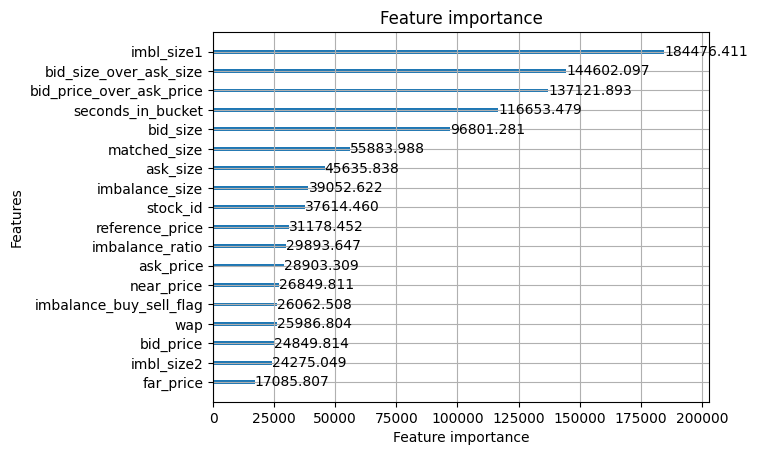

In [17]:
lgbm.plot_importance(lgbm_model, importance_type="gain")

# 7. Submission

As I said, this notebook is just a starter, and thus I'll submit at this point.   
In this competition, API provided by kaggle should be used.  

このNotebookはStarterとの位置づけですので、いったんこのあたりで提出してみます。  
このコンペでは、SubmissionにはKaggleから提供されているAPIを利用します。

In [18]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [19]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test = pre_process1(test)
    test_df = feature_cols(test)
    sample_prediction['target'] = lgbm_model.predict(test_df)
    env.predict(sample_prediction)
    
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [20]:
sample_prediction

,row_id,target
0,480_540_0,-0.436964
1,480_540_1,0.658475
2,480_540_2,0.593363
3,480_540_3,-1.496866
4,480_540_4,-1.354730
...,...,...
195,480_540_195,-2.455686
196,480_540_196,-1.559976
197,480_540_197,0.666114
198,480_540_198,1.878609
